<a href="https://colab.research.google.com/github/Git-Hub-Pro/ML_STUDY_BY_KAGGLE/blob/master/2018DatScienceBowl_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
# pathlib에 대한 설명 https://ryanking13.github.io/2018/05/22/pathlib.html
training_paths = pathlib.Path('../content/gdrive/My Drive/data/kaggle_data/stage1_train').glob('*/images/*.png')
# 이미지들을 순서대로 정렬한다.
training_sorted = sorted([x for x in training_paths])
# 임의의 이미지를 가지고 온다.
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

In [0]:
# 전반적인 내용은 
# 전처리로는 img 파일을 gray img로 변환 후, 가우시안 필터링으로 이진화 이미지로 만듭니다. 그리고 데이터양이 작은 부분을 물체로 판단합니다.
# 물체를 구분하기 위해, Segmentation으로는 라벨링(보통,BFS,DFS로 구현)으로 물체를 나누었습니다.
# 그리고 결과값은 RLE Encoding으로 데이터를 축소 후, 데이터를 합쳐서 제출하는 코드입니다.

In [0]:
# Dealing with color 
# scikit-image를 활용하여 데이터 처리

Original image shape: (520, 696, 4)
New image shape: (520, 696)


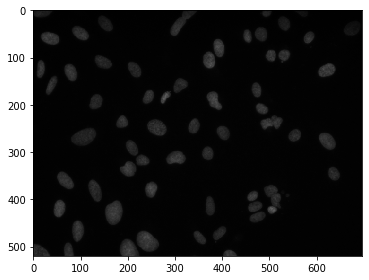

In [13]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
from skimage import io

im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

io.imshow(im_gray)
io.show()

In [0]:
!sudo apt-get install python-skimage

In [0]:
# Removing background 가우시안 필터를 활용하여 노이즈를 지우고, mask를 만든다.
from skimage import data, io, filters
# from skimage.filters import threshold_ostu
thresh_val = filters.threshold_otsu(im_gray)
img_thresh = np.where(im_gray>thresh_val,1,0)

# 배경이 물체보다 영역의 크기가 더 크므로, 영역의 큰 부분은 1의 값으로 만들어주고, 영역이 작은 부분은 0으로 만들어준다.
if np.sum(img_thresh==0) < np.sum(img_thresh==1):
    img_thresh = np.where(img_thresh,0,1)    

In [21]:
 # scipy 라이브러리를 통하여 라벨링을 해주고 각각의 물체에 번호를 부여해 준다.그리고 난 후, 각각의 라벨링 번호를 바탕으로 각각의 물체에 맞는 mask를 만들어준다.
 # 여기서 mask란 해당 이미지를 제외하고 출력을 해주지 않게 해주는 filter 또는 망,채 정도로 생각하면 됩니다.
 from scipy import ndimage
 # 라벨링 된 데이터와 라벨링 수를 반환해줍니다.
 labels, nlabels = ndimage.label(img_thresh)

 label_arrays = []
 for label_num in range(1,nlabels+1):
     label_mask = np.where(labels==label_num,1,0)
     label_arrays.append(label_mask)
 print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


In [22]:
# 라벨링된 이미지 출력하기, 사이즈의 갯수가 작은 부분은 출력하지 않기
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]

    # 사이즈의 갯수가 10보다 작으면 없앤다. Check if the label size is too small
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0'.format(label_ind))
        img_thresh = np.where(labels==label_ind+1,0,img_thresh)

# 라벨링을 업데이트 한다. Regenerate the labels
labels, nlabels = ndimage.label(img_thresh)
print('There are now {} seperate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0
Label 5 is too small! Setting to 0
Label 7 is too small! Setting to 0
Label 8 is too small! Setting to 0
Label 9 is too small! Setting to 0
Label 10 is too small! Setting to 0
Label 14 is too small! Setting to 0
Label 15 is too small! Setting to 0
Label 16 is too small! Setting to 0
Label 19 is too small! Setting to 0
Label 21 is too small! Setting to 0
Label 22 is too small! Setting to 0
Label 23 is too small! Setting to 0
Label 60 is too small! Setting to 0
Label 61 is too small! Setting to 0
Label 72 is too small! Setting to 0
There are now 60 seperate components / objects detected.


In [0]:
# Get the object indice, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = img_thresh[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask,iterations=8)

In [27]:
import pandas as pd
# Run-Length Encoding
# Run-Length 압축법은 동일한 문자가 이어서 반복되는 경우 그것을 문자와 개수의 쌍으로 치환하는 방법이다. 
# ex) original : ABAAAAAA -> compressed : ABA5 ,Kaggle user Rakhlin's kernel
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


In [0]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # 그레이 스케일로 변환 Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)

    # 데이터양이 큰 부분을 배경으로 인식하고 지운다. Mask out background and extract connected objects
    thresh_val = filters.threshold_otsu(im_gray)
    img_thresh = np.where(im_gray>thresh_val,1,0)
    if np.sum(img_thresh==0) <np.sum(img_thresh==1):
        img_thresh = np.where(img_thresh,0,1)
        labels, nlabels = ndimage.label(img_thresh)
    labels, nlabels = ndimage.label(img_thresh)

    # 라벨링을 실시한다. Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1,nlabels+1):
        label_mask = np.where(labels==label_num,1,0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId':im_id,'EncodedPixels':rle})
            im_df = im_df.append(s,ignore_index=True)
    
    return im_df

def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.
    '''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df,ignore_index=True)
    
    return all_df

In [0]:
testing = pathlib.Path('../content/gdrive/My Drive/data/kaggle_data/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('../content/gdrive/My Drive/data/kaggle_data/submission.csv',index=None)